# Data Split and Model Baseline

### Imports

In [0]:
import sys, os
import numpy as np
import pandas as pd
import re
import tempfile
import time
import subprocess
import matplotlib.pyplot as plt


from google.colab import drive
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, train_test_split
#from utils import elapsed_time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, classification_report, f1_score, roc_auc_score,  roc_curve


%reload_ext autoreload
%autoreload 2


pd.set_option('display.max_colwidth', -1)


### Colab setup

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
cd ~/..

/


In [4]:
os.getcwd()

'/'

**Notice:** There is an issue related to whitespace in "My Drive" when trying to invoke path with it. As for now google colab does not allow to rename e.g. to "MyDrive". One walkaround is to create a symbolic link to omit problem with whitespace within "My Drive". 

In [0]:
# Create a symbolic link to omit issues with whitespace in "My Drive"
!ln -s ~/../content/gdrive/"My Drive"/ /MyDrive

In [0]:
PROJECT_HOME_PATH = os.path.join('/MyDrive', 'NmtPolishLanguage')
DATA_PATH = os.path.join(PROJECT_HOME_PATH, 'DATA')

In [17]:
os.path.exists(PROJECT_HOME_PATH)

True

In [18]:
ls

bin/      datalab/  home/   lib64/  MyDrive@  root/  srv/    tmp/    var/
boot/     dev/      lib/    media/  opt/      run/   swift/  tools/
content/  etc/      lib32/  mnt/    proc/     sbin/  sys/    usr/


### Split dataset

Train and test set are stored in separated train, test directories

#### Load dataset

In [0]:
df_data = joblib.load(os.path.join(DATA_PATH, 'interim', 'hate_speech_mod.dat'))
df_data = df_data.loc[:, ['text_mod', 'target']]
df_data.columns = ['text', 'target']
df_data.target = df_data.target.astype(np.uint8)

In [30]:
df_data.head(3)

,text,target
0,faworytem do tytulu cracovia zobaczymy typ sprawdzi,0
1,anonymizedaccount anonymizedaccount brawo daria kibic dobre zle,0
2,anonymizedaccount anonymizedaccount super polski premier sklada kwiaty grobach kolaborantow doczekalismy czasow,0


#### Split

In [0]:
notes_trn, notes_test, y_trn, y_test = train_test_split(df_data.text, df_data.target, test_size=0.20, random_state=42, stratify=df_data.target)

trn = pd.concat([notes_trn, y_trn], axis=1)
test = pd.concat([notes_test, y_test], axis=1)

In [0]:
trn.to_csv(os.path.join(DATA_PATH, 'train', 'train_notes.csv'), index=False)
test.to_csv(os.path.join(DATA_PATH, 'test', 'test_notes.csv'), index=False)

### Model Baseline

#### Metrics

In [0]:
def calc_fscore(y_true, y_pred):
    print(f'F-score: {f1_score(y_true, y_pred):.4f}')
    
def calc_classRep(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    
def draw_pred_distr(pred_proba):
    plt.hist(pred_proba)
    _ = plt.axvline(x=0.5, color='orange')
    
def calc_conf_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), index=['actual_0', 'actual_1'], columns=['pred_0', 'pred_1'])


def draw_roc_curve(y_true, pred_proba):
    
    fpr, tpr, _ = roc_curve(y_true, pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    

#### Load data

In [0]:
train_notes = pd.read_csv(os.path.join(DATA_PATH, 'train', 'train_notes.csv'))
test_notes = pd.read_csv(os.path.join(DATA_PATH, 'test', 'test_notes.csv'))

notes_trn = train_notes['text']
y_trn = train_notes['target']

notes_test = test_notes['text']
y_test = test_notes['target']


#### TfidfVectorizer

In [0]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=2000)

In [110]:
tfidf_vect.fit(notes_trn)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
xtrain_tfidf = tfidf_vect.transform(notes_trn)

In [0]:
xtest_tfidf = tfidf_vect.transform(notes_test)

In [113]:
xtrain_tfidf.shape

(8031, 2000)

#### Fit model

In [114]:
nb = MultinomialNB()
nb.fit(xtrain_tfidf, y_trn)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
pred_test = nb.predict(xtest_tfidf)

In [0]:
pred_proba = nb.predict_proba(xtest_tfidf)[:, 1]

In [117]:
calc_fscore(y_test, pred_test)

F-score: 0.0343


In [118]:
calc_classRep(y_test, pred_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1838
           1       0.60      0.02      0.03       170

   micro avg       0.92      0.92      0.92      2008
   macro avg       0.76      0.51      0.50      2008
weighted avg       0.89      0.92      0.88      2008



In [119]:
calc_conf_matrix(y_test, pred_test)

,pred_0,pred_1
actual_0,1836,2
actual_1,167,3


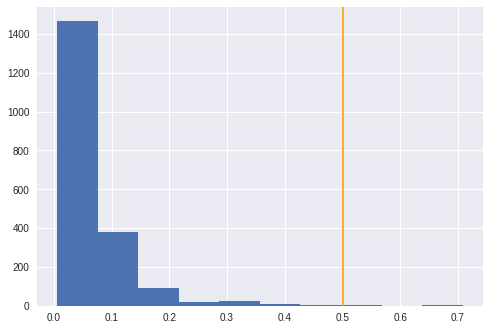

In [120]:
draw_pred_distr(pred_proba)

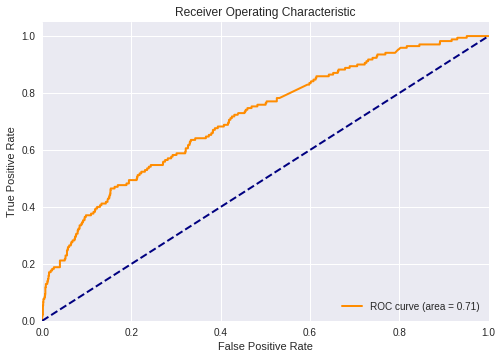

In [121]:
draw_roc_curve(y_test, pred_proba)

In [122]:
lr = LogisticRegression(C=10)
lr.fit(xtrain_tfidf, y_trn)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pred_test = lr.predict(xtest_tfidf)

In [0]:
pred_proba = lr.predict_proba(xtest_tfidf)[:, 1]

In [125]:
calc_fscore(y_test, pred_test)

F-score: 0.2544


In [126]:
calc_classRep(y_test, pred_test)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1838
           1       0.50      0.17      0.25       170

   micro avg       0.92      0.92      0.92      2008
   macro avg       0.71      0.58      0.60      2008
weighted avg       0.89      0.92      0.90      2008



In [127]:
calc_conf_matrix(y_test, pred_test)

,pred_0,pred_1
actual_0,1809,29
actual_1,141,29


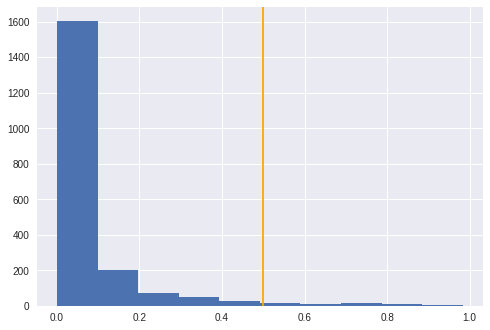

In [128]:
draw_pred_distr(pred_proba)

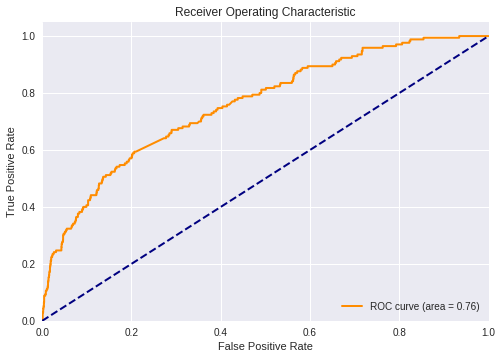

In [129]:
draw_roc_curve(y_test, pred_proba)

In [0]:
lr = LogisticRegression(C=10)

In [131]:
scores = cross_val_score(lr, xtrain_tfidf, y_trn, cv=5, scoring='f1')

print(f'F-score: {scores.mean():.3f}\nstd: {scores.std():.3f}')

F-score: 0.285
std: 0.024


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
